#This model uses LSTM to predict a Daily share price movements based on time series and batches of 60 days

# Read the CSV and Perform Basic Data Cleaning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
df_stock1 = pd.read_csv("../static/data/anz.csv")
# Drop the null columns where all values are null
df_stock2 = df_stock1.dropna(axis='columns', how='all')
# Drop the null rows
df = df_stock2.dropna()
# Drop the last rows to test prediction to actual
df_stock_less1= df_stock2.iloc[:-1,:]
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,RBA,FED,CPI
8859,1/08/2022,22.799999,22.799999,22.420000,22.740000,22.740000,7611230.0,1.35,2.5,125.0
8860,2/08/2022,22.440001,22.860001,22.410000,22.809999,22.809999,6999769.0,1.35,2.5,125.0
8861,3/08/2022,22.590000,22.770000,22.459999,22.709999,22.709999,5322088.0,1.85,2.5,125.0
8862,4/08/2022,22.629999,22.930000,22.629999,22.780001,22.780001,6167647.0,1.85,2.5,125.0
8863,5/08/2022,22.830000,22.879999,22.740000,22.850000,22.850000,834259.0,1.85,2.5,125.0


In [3]:
# Connect to MongoDb
from pymongo import MongoClient
mongoClient = MongoClient()
db = mongoClient.sharesDB

# # Drop all previous records now in MongoDb
# db.anz.drop()

# # Insert df records in mongodb
# records=df.to_dict('records')
# records
# db.anz.insert_many(records)

In [4]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.anz.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("DELETE: "+last_date,last_close)

db.anz.delete_one(
    {'Date': last_date}
)


DELETE: 29/08/2022 22.440000534057617


In [5]:
first_val = df_mongo.iloc[:1].values
first_date = first_val[0][1]
print(first_val,first_date)


[[ObjectId('62ec6db62b39ed09ae95159e') '1/02/1988' 3.205835 3.205835
  3.205835 3.205835 0.46378 0.0 17.5 9.97 48.4]] 1/02/1988


In [6]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.anz.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("NEW LAST VALUE IN MONGODB: "+last_date,last_close)

from datetime import date,datetime
todaydt = date.today()
today=todaydt.strftime('%d-%m-%Y')
from_date = datetime.strptime(last_date, '%d/%m/%Y')
last_date=from_date.strftime('%d-%m-%Y')
print("Previous last date in MongoDb: "+last_date+". Today's date: "+today)

NEW LAST VALUE IN MONGODB: 26/08/2022 22.959999084472656
Previous last date in MongoDb: 26-08-2022. Today's date: 01-09-2022


In [7]:
#Get latest quotes from yahoo finance:
import pandas_datareader.data as web
symbol = 'ANZ.AX'
start = from_date # yyyy-mm-dd

end = todaydt  # yyyy-mm-dd
stock_quote = web.DataReader(symbol,data_source='yahoo',start=start, end=end) # dataframe
stock_quote


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-08-26,23.139999,22.799999,22.870001,22.959999,4767145,22.959999
2022-08-29,22.590000,22.250000,22.480000,22.440001,5463481,22.440001
2022-08-30,22.760000,22.490000,22.510000,22.570000,4641152,22.570000
2022-08-31,22.870001,22.420000,22.559999,22.830000,8705496,22.830000


In [8]:
#remove last date already in mongodb
stock_quote=stock_quote.iloc[1:]
stock_quote

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-08-29,22.590000,22.25,22.480000,22.440001,5463481,22.440001
2022-08-30,22.760000,22.49,22.510000,22.570000,4641152,22.570000
2022-08-31,22.870001,22.42,22.559999,22.830000,8705496,22.830000


In [9]:
tot=len(stock_quote)
rba=1.85
fed=2.5
cpi=125
a,b,c=[],[],[]
for i in range(tot):
    a.append(rba)
    b.append(fed)
    c.append(cpi)
# print(a,b,c)
#ADD NEW DATA IN DATAFRAME
stock_quote["RBA"],stock_quote["FED"],stock_quote["CPI"] = a,b,c
stock_quote.reset_index(inplace=True)

stock_quote['Date'] = pd.to_datetime(stock_quote['Date'])
stock_quote['Date']=stock_quote['Date'].dt.strftime('%d/%m/%Y')
stock_quote['Date']=stock_quote['Date'].astype(str)
stock_quote

C:\Users\antoi\AppData\Local\Temp/ipykernel_43612/307716900.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_quote["RBA"],stock_quote["FED"],stock_quote["CPI"] = a,b,c
C:\Users\antoi\AppData\Local\Temp/ipykernel_43612/307716900.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_quote['Date'] = pd.to_datetime(stock_quote['Date'])
C:\Users\antoi\AppData\Local\Temp/ipykernel_43612/307716900.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

,Date,High,Low,Open,Close,Volume,Adj Close,RBA,FED,CPI
0,29/08/2022,22.590000,22.25,22.480000,22.440001,5463481,22.440001,1.85,2.5,125
1,30/08/2022,22.760000,22.49,22.510000,22.570000,4641152,22.570000,1.85,2.5,125
2,31/08/2022,22.870001,22.42,22.559999,22.830000,8705496,22.830000,1.85,2.5,125


UPDATE MONGO DB

In [10]:
records=stock_quote.to_dict('records')
records

[{'Date': '29/08/2022',
  'High': 22.59000015258789,
  'Low': 22.25,
  'Open': 22.479999542236328,
  'Close': 22.440000534057617,
  'Volume': 5463481,
  'Adj Close': 22.440000534057617,
  'RBA': 1.85,
  'FED': 2.5,
  'CPI': 125},
 {'Date': '30/08/2022',
  'High': 22.760000228881836,
  'Low': 22.489999771118164,
  'Open': 22.510000228881836,
  'Close': 22.56999969482422,
  'Volume': 4641152,
  'Adj Close': 22.56999969482422,
  'RBA': 1.85,
  'FED': 2.5,
  'CPI': 125},
 {'Date': '31/08/2022',
  'High': 22.8700008392334,
  'Low': 22.420000076293945,
  'Open': 22.559999465942383,
  'Close': 22.829999923706055,
  'Volume': 8705496,
  'Adj Close': 22.829999923706055,
  'RBA': 1.85,
  'FED': 2.5,
  'CPI': 125}]

In [11]:
#INSERT NEW DATA INTO MONGODB
db.anz.insert_many(records)

#Check if mongoDb now has latest data
df_mongo = pd.DataFrame(list(db.anz.find()))

last_val = df_mongo.iloc[-10:].values
print(last_val)

[[ObjectId('62ff3d94d7b62f09770fc7e5') '18/08/2022' 23.780000686645508
  23.895000457763672 23.530000686645508 23.579999923706055
  23.579999923706055 6744098.0 1.85 2.5 125.0]
 [ObjectId('630332d6794cb456bf9cc928') '19/08/2022' 23.350000381469727
  23.3799991607666 22.93000030517578 23.100000381469727
  23.100000381469727 12048214.0 1.85 2.5 125.0]
 [ObjectId('63049caa8c95607a95233304') '22/08/2022' 23.0
  23.049999237060547 22.829999923706055 22.84000015258789
  22.84000015258789 6144588.0 1.85 2.5 125.0]
 [ObjectId('630726983d15c65935244f2f') '23/08/2022' 22.639999389648438
  22.639999389648438 22.389999389648438 22.450000762939453
  22.450000762939453 7354537.0 1.85 2.5 125.0]
 [ObjectId('63075763d274ab50258f0a8b') '24/08/2022' 22.459999084472656
  22.829999923706055 22.459999084472656 22.809999465942383
  22.809999465942383 8602395.0 1.85 2.5 125.0]
 [ObjectId('630ae5955a6b6e1bacec69e1') '25/08/2022' 22.790000915527344
  22.899999618530273 22.709999084472656 22.860000610351562
  2

In [12]:
#Save latest to variables
last_val = df_mongo.iloc[-1:].values
last_date = last_val[0][1]
last_close = last_val[0][5]
print(last_date,last_close)

31/08/2022 22.829999923706055


# # Pre-processing : Scale the data using the MinMaxScaler and split train data

In [13]:
df_mongo = pd.DataFrame(list(db.anz.find()))
# Drop the null columns where all values are null
df_mongo = df_mongo.dropna(axis='columns', how='all')
# Drop the null rows
df_mongo = df_mongo.dropna()
# df_mongo.shape

len_df_mongo=len(df_mongo)
data = df_mongo.filter(["Close"])
dataset=data.values
dataset.shape

(8718, 1)

In [14]:
# data = df.filter(['Close'])
# dataset = data.values
# dataset.shape	

In [15]:
# Scale your data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
dataset_scaled = scaler.fit_transform(dataset)

# Split into train or test
import math
train_data_len = math.ceil(len(dataset)*.8)
train_data = dataset_scaled[0:train_data_len,:]
train_data.shape


(6975, 1)

In [16]:
X_train = []
y_train = []

for i in range (60, len(train_data)):
    X_train.append(train_data[i-60:i,0]) # contains 60 values
    y_train.append(train_data[i,0])   # contains 61st value
    if i<= 60:
        print(X_train)
        print(y_train) 


[array([0.01592121, 0.01592121, 0.01592121, 0.01592121, 0.01592121,
       0.01592121, 0.01592121, 0.01592121, 0.01592121, 0.01592121,
       0.01592121, 0.01592121, 0.01592121, 0.01592121, 0.01592121,
       0.01592121, 0.01592121, 0.01592121, 0.01592121, 0.01592121,
       0.02142814, 0.02142814, 0.02142814, 0.02142814, 0.02142814,
       0.02142814, 0.02142814, 0.02142814, 0.02142814, 0.02142814,
       0.02142814, 0.02142814, 0.02142814, 0.02142814, 0.02142814,
       0.02142814, 0.02142814, 0.02142814, 0.02142814, 0.02142814,
       0.02142814, 0.02142814, 0.03322874, 0.03322874, 0.03322874,
       0.03322874, 0.03322874, 0.03322874, 0.03322874, 0.03322874,
       0.03322874, 0.03322874, 0.03322874, 0.03322874, 0.03322874,
       0.03322874, 0.03322874, 0.03322874, 0.03322874, 0.03322874])]
[0.03322874361422559]


# Prepare train data for LSTM model

In [17]:
# Convert list to numpy array for LSTM model:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(6915, 60)

In [18]:
# LSTM model expects 3D, reshape:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(6915, 60, 1)

# Build the LSTM model

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [20]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [21]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

6915/6915 [==============================] - 403s 58ms/step - loss: 6.6913e-04


In [22]:
#Create test data
test_data = dataset_scaled[train_data_len-60:,:]
X_test = []
y_test = dataset[train_data_len:,:]
for i in range(60, len(test_data)):
 X_test.append(test_data[i-60:i,0])

In [23]:
#Covert test data to a numpy array and reshape
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [24]:
#Get predicted prices
predictions_lstm = model.predict(X_test)
predictions = scaler.inverse_transform(predictions_lstm)

In [25]:
#Get the root mean square error (RMSE) 0 being most favourable
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

0.4301922940479132

In [26]:
# first_value = df_mongo.iloc[:1].values
# first_date = first_value[0][1]
# print(first_date,last_date)

C:\Users\antoi\AppData\Local\Temp/ipykernel_43612/2962187845.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


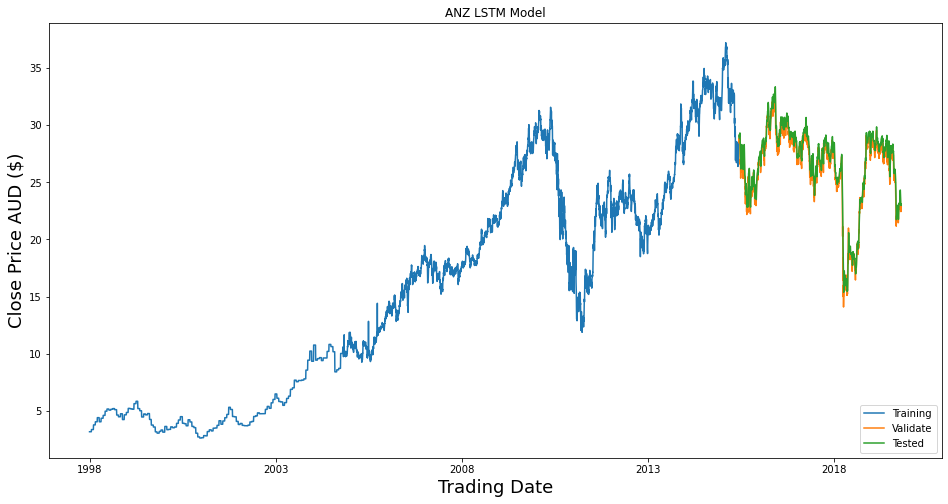

In [27]:
#Plot the data to validate the test data
# plt.style.use('fivethirtyeight')
train = data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = data.iloc[train_data_len:] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test

plt.figure(figsize=(16,8))
plt.title('ANZ LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Training','Validate','Tested'],loc='lower right')
x = np.arange(1998,2023,5)# 25yrs/5labels=5steps
plt.xticks([0,2000,4000,6000,8000],x)
plt.savefig('../static/data/images/anz_graph.png')
plt.show()

# Test data Predictions on the Model

In [28]:
valid['Difference']= valid['Close']-valid['Predictions']
valid.head

C:\Users\antoi\AppData\Local\Temp/ipykernel_43612/3403988079.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Difference']= valid['Close']-valid['Predictions']


<bound method NDFrame.head of           Close  Predictions  Difference
6975  28.650000    28.896683   -0.246683
6976  28.559999    29.022341   -0.462342
6977  28.670000    29.054678   -0.384678
6978  28.860001    29.083775   -0.223774
6979  28.400000    29.165173   -0.765173
...         ...          ...         ...
8713  22.860001    23.028234   -0.168234
8714  22.959999    23.035845   -0.075846
8715  22.440001    23.127125   -0.687124
8716  22.570000    23.042509   -0.472509
8717  22.830000    22.986975   -0.156975

[1743 rows x 3 columns]>

In [29]:
# Use last 60 days price on model to predict next days price
import pandas as pd

df_mongo = pd.DataFrame(list(db.anz.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty.shape

(60, 1)

In [30]:
last_60_days_scaled = scaler.transform(last_sixty)
X_tell = []
X_tell.append(last_60_days_scaled)
X_tell =np.array(X_tell)
X_tell =np.reshape(X_tell, (X_tell.shape[0], X_tell.shape[1],1))
X_tell.shape

(1, 60, 1)

In [31]:
pred_price = model.predict(X_tell)
pred_price = scaler.inverse_transform(pred_price)
pred_price = round(float(pred_price),2)
print(f'{last_date} Last close ${last_close} Predicted next day share price ${pred_price}')

31/08/2022 Last close $22.829999923706055 Predicted next day share price $22.81


# Save the Model

In [32]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
filepath = '../static/anz_model.sav'
model.save(filepath, save_format="h5")

#Save last 60 days to a list anz_sixty and load df

#PREDICT USING LOADED MODEL

In [33]:
from keras.models import load_model
model_in = load_model('../static/anz_model.sav')

In [34]:
# query the anz collection and load into dataframe

df_mongo = pd.DataFrame(list(db.anz.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty

array([[23.799999  ],
       [23.129999  ],
       [23.01      ],
       [21.559999  ],
       [21.58      ],
       [21.43      ],
       [20.950001  ],
       [21.280001  ],
       [21.59      ],
       [21.780001  ],
       [21.870001  ],
       [21.75      ],
       [22.33      ],
       [22.129999  ],
       [22.290001  ],
       [22.030001  ],
       [22.        ],
       [22.209999  ],
       [21.969999  ],
       [22.030001  ],
       [22.370001  ],
       [22.639999  ],
       [22.440001  ],
       [22.302101  ],
       [22.173132  ],
       [21.756454  ],
       [21.210808  ],
       [21.46875   ],
       [21.46875   ],
       [21.46875   ],
       [21.27      ],
       [21.799999  ],
       [22.450001  ],
       [22.639999  ],
       [22.370001  ],
       [22.58      ],
       [22.73      ],
       [22.42      ],
       [22.41      ],
       [22.459999  ],
       [22.629999  ],
       [22.72999954],
       [22.70000076],
       [22.61000061],
       [22.80999947],
       [23

#Create a function to loop through the days input

In [35]:
from keras.models import load_model
model_in = load_model('../static/anz_model.sav')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

price_list=[]

#Function to predict future days predicted price, in loop
input = 180 #days
if input == "":
    input = 180
else:
   input = int(input)

def predict_anz(last_sixty,model_in,input):
    for i in range(1, input):

        #Takes df and converts to model's predict shape
        last_sixty_scaled = scaler.fit_transform(last_sixty)
        new_X_tell = []
        new_X_tell.append(last_sixty_scaled)
        new_X_tell =np.array(new_X_tell)
        new_X_tell =np.reshape(new_X_tell, (new_X_tell.shape[0], new_X_tell.shape[1],1))
        
        model_in_pd_scale = model_in.predict(new_X_tell)
        model_in_price = scaler.inverse_transform(model_in_pd_scale) # New price predicted

        last_sixty_less_one = np.delete(last_sixty, 0, 0)
        last_sixty = np.append(last_sixty_less_one, model_in_price,axis = 0) # Update last 60
        print(i)
        print("Day finished! Price: ")
        price_float = float(model_in_price)
        price = round(price_float, 2)
        price_list.append(price)
    else:
        print("Could not predict further!")
        print(input)
    # print(price_list)
    return price_list

price_pred = predict_anz(last_sixty,model_in,input)
price_pred

1
Day finished! Price: 
2
Day finished! Price: 
3
Day finished! Price: 
4
Day finished! Price: 
5
Day finished! Price: 
6
Day finished! Price: 
7
Day finished! Price: 
8
Day finished! Price: 
9
Day finished! Price: 
10
Day finished! Price: 
11
Day finished! Price: 
12
Day finished! Price: 
13
Day finished! Price: 
14
Day finished! Price: 
15
Day finished! Price: 
16
Day finished! Price: 
17
Day finished! Price: 
18
Day finished! Price: 
19
Day finished! Price: 
20
Day finished! Price: 
21
Day finished! Price: 
22
Day finished! Price: 
23
Day finished! Price: 
24
Day finished! Price: 
25
Day finished! Price: 
26
Day finished! Price: 
27
Day finished! Price: 
28
Day finished! Price: 
29
Day finished! Price: 
30
Day finished! Price: 
31
Day finished! Price: 
32
Day finished! Price: 
33
Day finished! Price: 
34
Day finished! Price: 
35
Day finished! Price: 
36
Day finished! Price: 
37
Day finished! Price: 
38
Day finished! Price: 
39
Day finished! Price: 
40
Day finished! Price: 
41
Day fi

[22.49,
 22.51,
 22.53,
 22.56,
 22.59,
 22.63,
 22.65,
 22.68,
 22.7,
 22.72,
 22.74,
 22.75,
 22.77,
 22.78,
 22.79,
 22.8,
 22.81,
 22.82,
 22.83,
 22.84,
 22.85,
 22.87,
 22.88,
 22.89,
 22.9,
 22.91,
 22.92,
 22.93,
 22.95,
 22.96,
 22.97,
 22.97,
 22.97,
 22.98,
 22.98,
 22.98,
 22.99,
 22.99,
 22.99,
 23.0,
 23.0,
 23.0,
 23.01,
 23.01,
 23.02,
 23.02,
 23.02,
 23.03,
 23.03,
 23.04,
 23.05,
 23.05,
 23.06,
 23.06,
 23.07,
 23.07,
 23.08,
 23.09,
 23.09,
 23.09,
 23.1,
 23.1,
 23.1,
 23.11,
 23.11,
 23.11,
 23.12,
 23.12,
 23.12,
 23.12,
 23.12,
 23.13,
 23.13,
 23.13,
 23.13,
 23.13,
 23.14,
 23.14,
 23.14,
 23.14,
 23.14,
 23.14,
 23.15,
 23.15,
 23.15,
 23.15,
 23.15,
 23.15,
 23.15,
 23.16,
 23.16,
 23.16,
 23.16,
 23.16,
 23.16,
 23.16,
 23.16,
 23.16,
 23.17,
 23.17,
 23.17,
 23.17,
 23.17,
 23.17,
 23.17,
 23.17,
 23.17,
 23.17,
 23.17,
 23.18,
 23.18,
 23.18,
 23.18,
 23.18,
 23.18,
 23.18,
 23.18,
 23.18,
 23.18,
 23.18,
 23.18,
 23.18,
 23.18,
 23.18,
 23.18,
 23.18,
 

In [36]:
#APPEND PREDICTION DATES IN DATAFRAME
import pandas as pd
from datetime import date,datetime,timedelta
today1 = date.today()
count=[]
dates=[]
dow=[]
row=0
for x in range(1,293,1): 
  d=today1+timedelta(days=x)
  a=d.strftime("%A")
  if a != "Saturday" and a != "Sunday":
     dates.append(d.strftime('%d-%m-%Y'))
     dow.append(a)
     row=row+1
     count.append(row)

data = {'Count': count,
        'Date': dates,
        'DOW': dow
        }
dates_df = pd.DataFrame(data)
print (dates_df.tail)

<bound method NDFrame.tail of      Count        Date        DOW
0        1  02-09-2022     Friday
1        2  05-09-2022     Monday
2        3  06-09-2022    Tuesday
3        4  07-09-2022  Wednesday
4        5  08-09-2022   Thursday
..     ...         ...        ...
203    204  14-06-2023  Wednesday
204    205  15-06-2023   Thursday
205    206  16-06-2023     Friday
206    207  19-06-2023     Monday
207    208  20-06-2023    Tuesday

[208 rows x 3 columns]>


In [37]:
#UPDATE DATES IN MONGODB
today4 = date.today()
d=today4+timedelta(days=1)
d=d.strftime('%d-%m-%Y')
print("Today plus one day:   "+d)
#Check if mongoDb now has latest data
dates_df = pd.DataFrame(list(db.dates.find()))
d_mdb = dates_df.iloc[0,2]
print("Predicted next date in mongodb:   "+d_mdb)
# print(d,d_mdb)

def update_date():
    #APPEND PREDICTION DATES IN DATAFRAME
    import pandas as pd
    from datetime import date,datetime,timedelta
    today1 = date.today()
    count=[]
    dates=[]
    dow=[]
    row=0
    for x in range(1,293,1): 
        d=today1+timedelta(days=x)
        a=d.strftime("%A")
        if a != "Saturday" and a != "Sunday":
            dates.append(d.strftime('%d-%m-%Y'))
            dow.append(a)
            row=row+1
            count.append(row)

    data = {'Count': count,
            'Date': dates,
            'DOW': dow
            }
    dates_df = pd.DataFrame(data)
    print (dates_df.tail)
    # Drop all previous records now in MongoDb
    db.dates.drop()
    records=dates_df.to_dict('records')

    #INSERT NEW DATA INTO MONGODB
    db.dates.insert_many(records)

    #Check if mongoDb now has latest data
    dates_mongo = pd.DataFrame(list(db.dates.find()))
    dates_updated = dates_mongo.iloc[:,1:].values
    return dates_updated

if d==d_mdb:
    print("Awesome! dates are already correctly updated!")
else:
    print("Dates need to be updated"+d+"  "+d_mdb)
    dates_updated = update_date()
    print(dates_updated)



Today plus one day:   02-09-2022
Predicted next date in mongodb:   02-09-2022
Awesome! dates are already correctly updated!


In [38]:
dates_df = pd.DataFrame(list(db.dates.find()))
dates_val = dates_df.iloc[0:,1:]
dates_val

,Count,Date,DOW
0,1,02-09-2022,Friday
1,2,05-09-2022,Monday
2,3,06-09-2022,Tuesday
3,4,07-09-2022,Wednesday
4,5,08-09-2022,Thursday
...,...,...,...
203,204,14-06-2023,Wednesday
204,205,15-06-2023,Thursday
205,206,16-06-2023,Friday
206,207,19-06-2023,Monday


C:\Users\antoi\AppData\Local\Temp/ipykernel_43612/985190947.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_df_iloc['Price'] = price_list


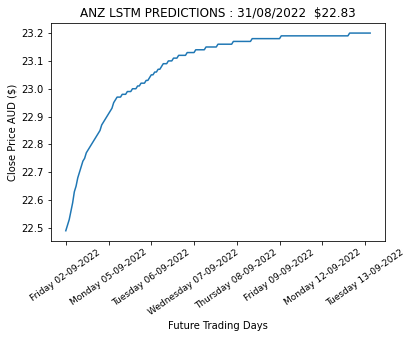

In [39]:
# DRAW THE PREDICTION
day1=dates_df.iloc[0,3]+" "+dates_df.iloc[0,2]
day2=dates_df.iloc[1,3]+" "+dates_df.iloc[1,2]
day3=dates_df.iloc[2,3]+" "+dates_df.iloc[2,2]
day4=dates_df.iloc[3,3]+" "+dates_df.iloc[3,2]
day5=dates_df.iloc[4,3]+" "+dates_df.iloc[4,2]
day6=dates_df.iloc[5,3]+" "+dates_df.iloc[5,2]
day7=dates_df.iloc[6,3]+" "+dates_df.iloc[6,2]
day8=dates_df.iloc[7,3]+" "+dates_df.iloc[7,2]
#Append the input amount of trading days to dates dictionary
dates_df_iloc = dates_df.iloc[0:(input-1)]
dates_df_iloc['Price'] = price_list
plt.plot(dates_df_iloc['Price'])
plt.title('ANZ LSTM PREDICTIONS : '+last_date+"  $"+str(round(last_close,2)))
plt.xlabel('Future Trading Days', fontsize=10)
plt.ylabel('Close Price AUD ($)',fontsize=10)
plt.xticks([0,25,50,75,100,125,150,175],[day1,day2,day3,day4,day5,day6,day7,day8],fontsize=9,rotation=35)
plt.savefig('../static/data/images/pred/anz_pred.png', bbox_inches="tight")
plt.show()

In [40]:
#Append the input amount of trading days to dates dictionary
my_dict = dates_df_iloc.to_dict(orient='records')
print(my_dict[0])
price_dict = [dict(zip(['Price'],[x])) for x in price_list]
# print(price_dict[0])

{'_id': ObjectId('630ffb2b41269e1989242178'), 'Count': 1, 'Date': '02-09-2022', 'DOW': 'Friday', 'Price': 22.49}


In [41]:
len_df_mongo = len(df_mongo) # length of the original dataframe
col_name = ['Close']
df_filtered = df.filter(col_name)
df_filtered_len = len(df_filtered.index)
df_filtered_len
len_pred_df = df_filtered_len+input # length of the original dataframe plus the users new inputs

new_data =df_filtered.append(pd.DataFrame(price_list,columns=col_name),ignore_index=True)
new_data.tail(10)
print(train_data_len,len_df_mongo,len_pred_df)


6975 8718 8880


C:\Users\antoi\AppData\Local\Temp/ipykernel_43612/3168330912.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


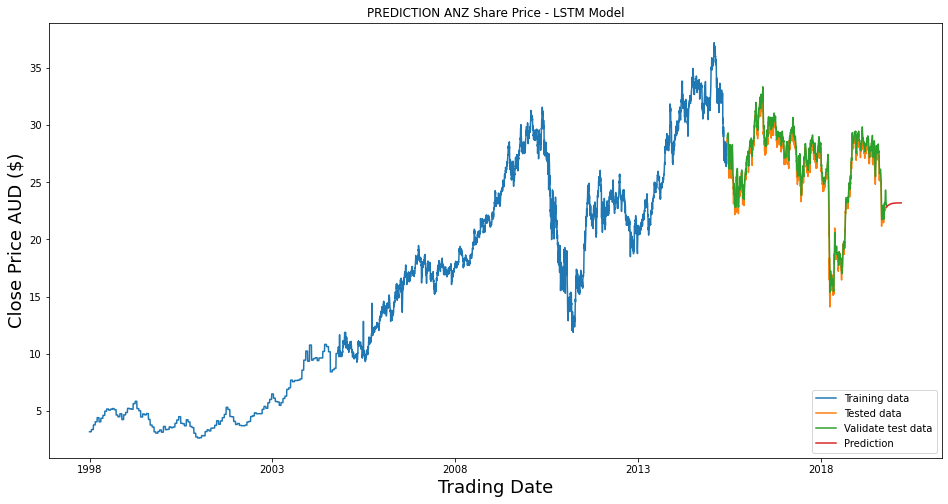

In [42]:
#Plot the data to validate the test data

# plt.style.use('fivethirtyeight')
train = new_data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = new_data.iloc[train_data_len:len_df_mongo] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test
predict = new_data.iloc[len_df_mongo:len_pred_df] # user prediction data from loop

plt.figure(figsize=(16,8))
plt.title('PREDICTION ANZ Share Price - LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.plot(predict['Close'])
plt.legend(['Training data','Tested data','Validate test data','Prediction'],loc='lower right')
x = np.arange(1998,2023,5)
plt.xticks([0,2000,4000,6000,8000],x)
plt.savefig('../static/data/images/anz_predict_graph.png')
plt.show()

#Save predicted price to MongoDB

In [43]:
# Query all
name = 'ANZ'
companys = db.companys.find({'name': name})
# Iterate through each company in the collection
for company in companys:
    print(company)

{'_id': ObjectId('62f72d88ba70ff4c205ba17f'), 'model': 'RFR', 'name': 'ANZ', 'date': '12/08/2022', 'predicted': 33, 'actual': 24, 'difference': 9.1995, 'accuracy': 97.17}
{'_id': ObjectId('630dc69746f8c2c8be21d8ae'), 'model': 'LSTM', 'name': 'ANZ', 'date': '30/08/2022', 'predicted': 22.59, 'actual': 22.57, 'difference': 0.02, 'rmse': 0.19239}


In [44]:
# Delete a document from a collection
db.companys_agg.delete_one(
    {'model': 'LSTM','name': name,'date':last_date}
)

db.companys.delete_one(
    {'model': 'LSTM','name': name}
)

# query the companys collection
companys = db.companys.find({'name': name})
# see change in the collection
for company in companys:
    print(company)

{'_id': ObjectId('62f72d88ba70ff4c205ba17f'), 'model': 'RFR', 'name': 'ANZ', 'date': '12/08/2022', 'predicted': 33, 'actual': 24, 'difference': 9.1995, 'accuracy': 97.17}


In [45]:
# Set keys and values of company
name = 'ANZ'
# Set keys and values of company
last_close=round(float(last_close),2)
difference = pred_price-last_close
print(f'date {last_date},predicted ${pred_price}, actual ${last_close}, difference {difference}, rmse {round(rmse,5)}')

date 31/08/2022,predicted $22.81, actual $22.83, difference -0.019999999999999574, rmse 0.43019


In [46]:
# Insert a document into the 'companys' collection
db.companys_agg.insert_one(
    {
      'model': 'LSTM',
      'name': name,
      'date': last_date,
      'predicted': pred_price,
      'actual': last_close,
      'difference': round(difference,4),
      'rmse': round(rmse,5)        
    }
)

db.companys.insert_one(
    {
      'model': 'LSTM',
      'name': name,
      'date': last_date,
      'predicted': pred_price,
      'actual': last_close,
      'difference': round(difference,4),
      'rmse': round(rmse,5)        
    }
)

# query the classroom collection
companys = db.companys.find({'name': name})

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62f72d88ba70ff4c205ba17f'), 'model': 'RFR', 'name': 'ANZ', 'date': '12/08/2022', 'predicted': 33, 'actual': 24, 'difference': 9.1995, 'accuracy': 97.17}
{'_id': ObjectId('630ffb2e429ec1dc0a0b0849'), 'model': 'LSTM', 'name': 'ANZ', 'date': '31/08/2022', 'predicted': 22.81, 'actual': 22.83, 'difference': -0.02, 'rmse': 0.43019}


In [47]:
# query all companys collection
companys = db.companys.find()

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62cfb5f0a3e49b5607e1001b'), 'model': 'RFR', 'name': 'nhc', 'date': '14/07/2022', 'predicted': 3, 'actual': 4, 'differece': -0.4134955929131614, 'accuracy': 95.31}
{'_id': ObjectId('62e47c25ddd32d7e027d5c65'), 'model': 'LSTM', 'name': 'fmg', 'date': '29/07/2022', 'predicted': 19, 'actual': 18.34, 'differece': 0.6600000000000001, 'rmse': 0.73826}
{'_id': ObjectId('62e481c2f248345c96c9494d'), 'model': 'RFR', 'name': 'fmg', 'date': '29/07/2022', 'predicted': 12, 'actual': 18, 'differece': -5.209653763866996, 'accuracy': 91.31}
{'_id': ObjectId('62e50595000bd2fa71a88d82'), 'model': 'RFR', 'name': 'wes', 'date': '29/07/2022', 'predicted': 44, 'actual': 38, 'difference': 6.9125, 'accuracy': 97.16}
{'_id': ObjectId('62e63809b66c4b7fa3db1a22'), 'model': 'RFR', 'name': 'anz', 'date': '29/07/2022', 'predicted': 33, 'actual': 22, 'difference': 11.1838, 'accuracy': 97.09}
{'_id': ObjectId('62ea3a74d27bca6473865515'), 'model': 'RFR', 'name': 'bhp', 'date': '02/08/2022', 'predicted'

In [48]:
# query all the classroom collection
companys = db.companys.find()

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62cfb5f0a3e49b5607e1001b'), 'model': 'RFR', 'name': 'nhc', 'date': '14/07/2022', 'predicted': 3, 'actual': 4, 'differece': -0.4134955929131614, 'accuracy': 95.31}
{'_id': ObjectId('62e47c25ddd32d7e027d5c65'), 'model': 'LSTM', 'name': 'fmg', 'date': '29/07/2022', 'predicted': 19, 'actual': 18.34, 'differece': 0.6600000000000001, 'rmse': 0.73826}
{'_id': ObjectId('62e481c2f248345c96c9494d'), 'model': 'RFR', 'name': 'fmg', 'date': '29/07/2022', 'predicted': 12, 'actual': 18, 'differece': -5.209653763866996, 'accuracy': 91.31}
{'_id': ObjectId('62e50595000bd2fa71a88d82'), 'model': 'RFR', 'name': 'wes', 'date': '29/07/2022', 'predicted': 44, 'actual': 38, 'difference': 6.9125, 'accuracy': 97.16}
{'_id': ObjectId('62e63809b66c4b7fa3db1a22'), 'model': 'RFR', 'name': 'anz', 'date': '29/07/2022', 'predicted': 33, 'actual': 22, 'difference': 11.1838, 'accuracy': 97.09}
{'_id': ObjectId('62ea3a74d27bca6473865515'), 'model': 'RFR', 'name': 'bhp', 'date': '02/08/2022', 'predicted'